In [163]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os



TIME_HORIZONS = [12,24,48,72,96] 

RATIOS = [

    (0.8, 1.0, 'QuickScalp'), 
   
    (0.8, 0.8, 'Balanced'),
    
    (1.618, 1.2, 'Sniper'),
 
    (2.0, 1.0, 'Classic'),
    
    (2.5, 1.5, 'Growth'),

    (3.236, 2.0, 'Trend'),

    (4.854, 3.0, 'BigTrend')
]



RAW_DATA_PATH_4H = "eth_4hour_all.csv"
RAW_DATA_PATH_5M = "eth_5min_krw.csv"
FEE_RATE = 0.0015
MIN_VOL_PCT = 0.002



In [54]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# 1. 데이터 로드
file_path = 'eth_4hour_all.csv'
df = pd.read_csv(file_path)
def load_and_standardize(path):
    if not os.path.exists(path):
        print(f"❌ File not found: {path}")
        return pd.DataFrame()

    df = pd.read_csv(path)
    df.columns = df.columns.str.strip().str.lower()
    
    rename_map = {}
    for col in df.columns:
        if 'eth_' in col: rename_map[col] = col.replace('eth_', '')
    if rename_map: df.rename(columns=rename_map, inplace=True)
        
    time_col = [c for c in df.columns if 'time' in c or 'date' in c][0]
    df[time_col] = pd.to_datetime(df[time_col])
    df.set_index(time_col, inplace=True)
    
    # 중복 제거 및 정렬
    df = df[~df.index.duplicated(keep='first')].sort_index()
    return df
df=load_and_standardize(file_path)

In [164]:
def generate_master_label_matrix():
    print(">>> 데이터 로드 중...")
    df_4h = load_and_standardize(RAW_DATA_PATH_4H)
    df_5m = load_and_standardize(RAW_DATA_PATH_5M)

    start_common = max(df_4h.index.min(), df_5m.index.min())
    df_4h = df_4h[df_4h.index >= start_common].copy()
    df_5m = df_5m[df_5m.index >= start_common].copy()


    prev_close = df_4h['close'].shift(1)  
    tr1 = df_4h['high'] - df_4h['low']                  
    tr2 = (df_4h['high'] - prev_close).abs()             
    tr3 = (df_4h['low'] - prev_close).abs()               
    
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)   
    
    # 2. ATR 14기간 이동평균
    atr_val = tr.rolling(14).mean()

    df_4h['ATR_Ref'] = atr_val / df_4h['close']
    df_4h = df_4h.dropna(subset=['ATR_Ref'])
    
    # ATR 계산하느라 생긴 앞부분 결측치(NaN) 제거
    df_4h = df_4h.dropna(subset=['ATR_Ref'])
    # -------------------------------------------------------------------------
    
    results = []
    
    for i in tqdm(range(len(df_4h)), desc="Generating Labels"):
        if i + 1 >= len(df_4h): continue
        
        timestamp = df_4h.index[i]
        next_ts = df_4h.index[i+1]
        
        if next_ts not in df_4h.index: continue
        
        entry_price = df_4h.loc[next_ts, 'open']
        
        raw_vol_ratio = df_4h.iloc[i]['ATR_Ref']
        
        # 값이 없거나 0이면 패스
        if pd.isna(raw_vol_ratio) or raw_vol_ratio == 0: continue
            
        # 최소 변동성 보정 (너무 작으면 최소 0.2%라도 잡아라)
        volatility = max(raw_vol_ratio, MIN_VOL_PCT) 
        
        max_h = max(TIME_HORIZONS)
        end_window = next_ts + pd.Timedelta(hours=max_h)
        
        # 5분봉 데이터 최적화 로딩
        subset_full = df_5m.loc[next_ts : end_window]
        
        if subset_full.empty: continue
        
        row_data = {
            'signal_time': timestamp,
            'entry_time': next_ts,
            'entry_price': entry_price,
            'volatility': volatility 
        }
        
        for hours in TIME_HORIZONS:
            horizon_end = next_ts + pd.Timedelta(hours=hours)
            subset = subset_full.loc[:horizon_end]
            
            if subset.empty: continue
            
            for profit_mult, stop_mult, ratio_name in RATIOS:
                col_suffix = f"{hours}h_{ratio_name}"
                
                tp_price = entry_price * (1 + (volatility * profit_mult))
                sl_price = entry_price * (1 - (volatility * stop_mult))
                
                target = 0
                ret = 0.0
                
                sl_hits = subset.index[subset['low'] <= sl_price]
                tp_hits = subset.index[subset['high'] >= tp_price]
                
                first_sl = sl_hits[0] if len(sl_hits) > 0 else None
                first_tp = tp_hits[0] if len(tp_hits) > 0 else None
                
                if first_sl and first_tp:
                    if first_sl < first_tp: # 손절 선착
                        ret = (sl_price - entry_price) / entry_price - FEE_RATE
                        target = 0
                    else: # 익절 선착
                        ret = (tp_price - entry_price) / entry_price - FEE_RATE
                        target = 1
                elif first_sl: 
                    ret = (sl_price - entry_price) / entry_price - FEE_RATE
                    target = 0
                elif first_tp: 
                    ret = (tp_price - entry_price) / entry_price - FEE_RATE
                    target = 1
                else: # Time-out
                    exit_price = subset.iloc[-1]['close']
                    ret = (exit_price - entry_price) / entry_price - FEE_RATE
                    target = 0 
                
                row_data[f'target_{col_suffix}'] = int(target)
                row_data[f'return_{col_suffix}'] = ret
                row_data[f'tp_{col_suffix}'] = tp_price
                row_data[f'sl_{col_suffix}'] = sl_price
        
        results.append(row_data)
        
    if not results:
        print(" No label data generated.")
        return

    df_out = pd.DataFrame(results)
    df_out.set_index('signal_time', inplace=True)
    
    filename = "triple_barrier_atr_4.csv"
    df_out.to_csv(filename)
    print(f"\n 라벨링 완료! 저장됨: {filename} ({len(df_out)} rows)")
    print(f"   - Columns: {len(df_out.columns)}")

if __name__ == "__main__":
    generate_master_label_matrix()


>>> 데이터 로드 중...


Generating Labels: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15157/15157 [02:14<00:00, 112.39it/s]



 라벨링 완료! 저장됨: triple_barrier_atr_4.csv (15156 rows)
   - Columns: 143


In [30]:
# ==============================================================================
# Helper Function
# ==============================================================================
def load_and_standardize(path):
    if not os.path.exists(path):
        print(f"❌ File not found: {path}")
        return pd.DataFrame()

    df = pd.read_csv(path)
    df.columns = df.columns.str.strip().str.lower()
    
    rename_map = {}
    for col in df.columns:
        if 'eth_' in col: rename_map[col] = col.replace('eth_', '')
    if rename_map: df.rename(columns=rename_map, inplace=True)
        
    time_col = [c for c in df.columns if 'time' in c or 'date' in c][0]
    df[time_col] = pd.to_datetime(df[time_col])
    df.set_index(time_col, inplace=True)
    
    # 중복 제거 및 정렬
    df = df[~df.index.duplicated(keep='first')].sort_index()
    return df

# ==============================================================================
# Main Labeling Logic
# ==============================================================================

def generate_master_label_matrix():
    print(">>> 데이터 로드 중...")
    df_4h = load_and_standardize(RAW_DATA_PATH_4H)
    df_5m = load_and_standardize(RAW_DATA_PATH_5M)

    start_common = max(df_4h.index.min(), df_5m.index.min())
    df_4h = df_4h[df_4h.index >= start_common].copy()
    df_5m = df_5m[df_5m.index >= start_common].copy()
    
    df_4h['log_ret'] = np.log(df_4h['close'] / df_4h['close'].shift(1))
    
    df_4h['ATR_Ref'] = df_4h['log_ret'].ewm(span=50, min_periods=50).std()
    
    results = []
    total_scenarios = len(TIME_HORIZONS) * len(RATIOS)
    
    for i in tqdm(range(len(df_4h)), desc="Generating Labels"):
        if i + 1 >= len(df_4h): continue
        
        timestamp = df_4h.index[i]
        next_ts = df_4h.index[i+1]
        
        if next_ts not in df_4h.index: continue
        
        entry_price = df_4h.loc[next_ts, 'open']
        raw_vol = df_4h.iloc[i]['ATR_Ref']
        
        if pd.isna(raw_vol) or raw_vol == 0: continue
            
        min_vol = entry_price * MIN_VOL_PCT
        volatility = max(raw_vol, MIN_VOL_PCT) 
        max_h = max(TIME_HORIZONS)
        end_window = next_ts + pd.Timedelta(hours=max_h)
        subset_full = df_5m.loc[next_ts : end_window]
        
        if subset_full.empty: continue
        
        row_data = {
            'signal_time': timestamp,
            'entry_time': next_ts,
            'entry_price': entry_price,
            'volatility': volatility
        }
        
        for hours in TIME_HORIZONS:
            horizon_end = next_ts + pd.Timedelta(hours=hours)
            subset = subset_full.loc[:horizon_end]
            
            if subset.empty: continue
            
            for profit_mult, stop_mult, ratio_name in RATIOS:
                col_suffix = f"{hours}h_{ratio_name}"
                
                tp_price = entry_price *(1 +(volatility * profit_mult))
                sl_price = entry_price *(1 - (volatility * stop_mult))
                
                target = 0 # 기본값 0 (횡보)
                ret = 0.0
                
                sl_hits = subset.index[subset['low'] <= sl_price]
                tp_hits = subset.index[subset['high'] >= tp_price]
                
                first_sl = sl_hits[0] if len(sl_hits) > 0 else None
                first_tp = tp_hits[0] if len(tp_hits) > 0 else None
                
                if first_sl and first_tp:
                    if first_sl < first_tp: # 손절
                        ret = (sl_price - entry_price) / entry_price - FEE_RATE
                        target = 0
                    else: # 익절
                        ret = (tp_price - entry_price) / entry_price - FEE_RATE
                        target = 1
                elif first_sl: # 손절
                    ret = (sl_price - entry_price) / entry_price - FEE_RATE
                    target = 0
                elif first_tp: # 익절
                    ret = (tp_price - entry_price) / entry_price - FEE_RATE
                    target = 1
                else: # 횡보/시간만료
                    exit_price = subset.iloc[-1]['close']
                    ret = (exit_price - entry_price) / entry_price - FEE_RATE
                    target = 0 
                
                row_data[f'target_{col_suffix}'] = int(target)
                row_data[f'return_{col_suffix}'] = ret
                row_data[f'tp_{col_suffix}'] = tp_price
                row_data[f'sl_{col_suffix}'] = sl_price
        
        results.append(row_data)
        
    if not results:
        print("❌ No label data generated.")
        return

    df_out = pd.DataFrame(results)
    df_out.set_index('signal_time', inplace=True)
    
    filename = "triple_barrier_end_ema.csv"
    df_out.to_csv(filename)
    print(f"\n✅ 라벨링 완료! 저장됨: {filename} ({len(df_out)} rows)")
    print(f"   - Columns: {len(df_out.columns)}")

if __name__ == "__main__":
    generate_master_label_matrix()


>>> 데이터 로드 중...


Generating Labels: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15170/15170 [04:25<00:00, 57.17it/s]



✅ 라벨링 완료! 저장됨: triple_barrier_end_ema.csv (15119 rows)
   - Columns: 291


In [6]:
# import pandas as pd
# import numpy as np
# import pandas_ta as ta
# from tqdm import tqdm
# import os

# # ==============================================================================
# # [설정] 파일 경로 및 저장 설정
# # ==============================================================================
# RAW_DATA_PATH = "eth_4hour_all.csv"    
# LABEL_DATA_PATH = "triple_barrier_end_fibo.csv" 
# OUTPUT_PATH = "cusum_theory_fibo.csv"         

# # ==============================================================================
# # 1. Feature Engineering (추세 추종 & 정상성 최적화)
# # ==============================================================================
# import pandas as pd
# import numpy as np
# import pandas_ta as ta

# def create_features(df):
#     df = df.copy()
    
#     df.columns = df.columns.str.strip().str.lower()
    
#     # 기본 로그 수익률
#     if 'close' in df.columns:
#         df['log_ret'] = np.log(df['close'] / df['close'].shift(1)).fillna(0)
    
#     # -------------------------------------------------------------------------
#     # [1] Volatility & Bands (변동성)
#     # -------------------------------------------------------------------------
#     if 'close' in df.columns:
#         try:
#             bb = df.ta.bbands(close=df['close'], length=20, std=2)
#             if bb is not None:
#                 bbl = bb.iloc[:, 0]
#                 bbm = bb.iloc[:, 1]
#                 bbu = bb.iloc[:, 2]
#                 bb_range = bbu - bbl
#                 df['bb_pct'] = np.where(bb_range != 0, (df['close'] - bbl) / bb_range, 0.5)
#                 df['bb_width'] = np.where(bbm != 0, bb_range / bbm, 0)
#         except: pass

#     # [2] Normalized ATR
#     if 'high' in df.columns and 'low' in df.columns and 'close' in df.columns:
#         try:
#             natr = df.ta.natr(high=df['high'], low=df['low'], close=df['close'], length=14)
#             df['natr_14'] = natr
#         except: pass

#     # -------------------------------------------------------------------------
#     # [3] Trend Indicators (추세)
#     # -------------------------------------------------------------------------
#     if 'high' in df.columns and 'low' in df.columns and 'close' in df.columns:
#         try:
#             adx_df = df.ta.adx(high=df['high'], low=df['low'], close=df['close'], length=14)
#             if adx_df is not None:
#                 df['adx'] = adx_df.iloc[:, 0]
#                 df['dmn'] = adx_df.iloc[:, 2]
#         except: pass

#     if 'close' in df.columns:
#         for window in [20, 200]:
#             sma = df['close'].rolling(window).mean()
#             df[f'dist_ma_{window}'] = np.where(sma != 0, (df['close'] / sma) - 1, 0)

#     # =========================================================================
#     # [NEW] [3-2] Market Regime (시장 국면: 효율성 & Z-Score)
#     # =========================================================================
#     # 설명: CUSUM이 횡보장(Noise)에서 떴는지, 추세장(Trend)에서 떴는지 구분
#     if 'close' in df.columns:
#         # (1) Efficiency Ratio (Kaufman): 1에 가까울수록 깨끗한 추세, 0은 횡보
#         # 4시간봉 10개 = 40시간 기준
#         er_period = 10
#         change = (df['close'] - df['close'].shift(er_period)).abs()
#         volatility_sum = df['close'].diff().abs().rolling(er_period).sum()
#         df['efficiency_ratio'] = np.where(volatility_sum > 1e-9, change / volatility_sum, 0)

#         # (2) Z-Score (Weekly): 단기 과열 여부 판단 (42봉 = 1주일)
#         z_window = 42
#         roll_mean = df['close'].rolling(z_window).mean()
#         roll_std = df['close'].rolling(z_window).std()
#         df['z_score_week'] = np.where(roll_std > 1e-9, (df['close'] - roll_mean) / roll_std, 0)

#     # -------------------------------------------------------------------------
#     # [4] Volume (거래량)
#     # -------------------------------------------------------------------------
#     if 'volume' in df.columns:
#         vol_ma = df['volume'].rolling(20).mean()
#         df['vol_ratio'] = np.where(vol_ma > 0, df['volume'] / vol_ma, 1.0)

#         # =====================================================================
#         # [NEW] [4-2] Volume Quality (거래량의 질)
#         # =====================================================================
#         # (1) MFI (Money Flow Index): RSI에 거래량을 섞은 것. 
#         # CUSUM 발생 시 MFI가 낮다면 '가짜 반등'일 확률 높음
#         if 'high' in df.columns and 'low' in df.columns and 'close' in df.columns:
#             try:
#                 mfi = df.ta.mfi(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], length=14)
#                 df['mfi_14'] = mfi.fillna(50)
#             except: pass
            
#         # (2) VWAP Disparity: 현재가가 '거래량이 실린 평균단가'보다 위에 있는가?
#         # Rolling VWAP 구현 (24시간 = 6봉 기준)
#         if 'high' in df.columns and 'low' in df.columns and 'close' in df.columns:
#             try:
#                 # 간단한 Rolling VWAP 계산 (tp * vol) / vol
#                 tp = (df['high'] + df['low'] + df['close']) / 3
#                 pv = tp * df['volume']
                
#                 roll_pv = pv.rolling(6).sum()
#                 roll_v = df['volume'].rolling(6).sum()
                
#                 vwap_rolling = np.where(roll_v > 0, roll_pv / roll_v, df['close'])
#                 df['dist_vwap'] = (df['close'] / vwap_rolling) - 1
#             except: pass

#     # =========================================================================
#     # [NEW] [4-3] Microstructure (캔들 패턴)
#     # =========================================================================
#     if 'open' in df.columns and 'close' in df.columns and 'high' in df.columns and 'low' in df.columns:
#         # Candle Strength: 몸통이 전체 길이의 몇 %인가? (1에 가까울수록 장대양봉/음봉)
#         candle_range = df['high'] - df['low']
#         body_range = (df['close'] - df['open']).abs()
#         df['candle_strength'] = np.where(candle_range > 1e-9, body_range / candle_range, 0)
        
#         # Upper Shadow: 윗꼬리 비율 (매도 압력 확인용)
#         # 양봉일 때: High - Close, 음봉일 때: High - Open
#         upper_shadow = df['high'] - df[['close', 'open']].max(axis=1)
#         df['upper_shadow_ratio'] = np.where(candle_range > 1e-9, upper_shadow / candle_range, 0)

#     # -------------------------------------------------------------------------
#     # [5] On-Chain TVL
#     # -------------------------------------------------------------------------
#     tvl_cols = [c for c in df.columns if 'tvl' in c and 'change' not in c and 'ratio' not in c]
#     for tvl in tvl_cols:
#         df[f'{tvl}_pct_chg_24h'] = df[tvl].pct_change(periods=6).fillna(0)
#         ma180 = df[tvl].rolling(1080).mean() 
#         df[f'{tvl}_ma180_ratio'] = np.where(ma180 > 1e-9, df[tvl] / ma180, 1.0)
#         df[f'{tvl}_ma180_ratio_change'] = df[f'{tvl}_ma180_ratio'].diff().fillna(0)

#     # -------------------------------------------------------------------------
#     # [6] Macro & External 
#     # -------------------------------------------------------------------------
#     targets = ['btc_close', 'sp500', 'dxy', 'vix'] 
#     for t in targets:
#         if t in df.columns:
#             df[f'{t}_pct'] = df[t].pct_change().fillna(0)

#     # -------------------------------------------------------------------------
#     # [7] Sentiment
#     # -------------------------------------------------------------------------
#     if 'fear_greed' in df.columns:
#         df['fear_greed'] = df['fear_greed'] / 100.0

#     return df.replace([np.inf, -np.inf], np.nan).fillna(0)



# # ==============================================================================
# # 2. Main Pipeline (
# # ==============================================================================
# def generate_dataset(n):
#     print(">>> 1. 데이터 로드...")
    
#     # 파일 존재 확인
#     if not os.path.exists(RAW_DATA_PATH):
#         print(f"❌ Error: {RAW_DATA_PATH} not found.")
#         return pd.DataFrame()
        
#     df_raw = pd.read_csv(RAW_DATA_PATH)
    
#     # 컬럼명 정리 (eth_ 접두사 제거)
#     df_raw.columns = df_raw.columns.str.strip().str.lower()
#     rename_map = {}
#     for col in df_raw.columns:
#         if 'eth_' in col: rename_map[col] = col.replace('eth_', '')
#     if rename_map: df_raw.rename(columns=rename_map, inplace=True)
        
#     # 인덱스 설정
#     time_cols = [c for c in df_raw.columns if 'time' in c or 'date' in c]
#     if not time_cols:
#         print("❌ Error: Time column not found.")
#         return pd.DataFrame()
        
#     time_col = time_cols[0]
#     df_raw[time_col] = pd.to_datetime(df_raw[time_col])
#     df_raw.set_index(time_col, inplace=True)
#     df_raw.sort_index(inplace=True)
    
#     # 중복 제거
#     df_raw = df_raw[~df_raw.index.duplicated(keep='first')]

#     print(">>> 2. Feature Engineering (With Trend Indicators)...")
#     df_features = create_features(df_raw)

#     print(">>> 3. CUSUM 필터링 (Long-Only: 하락 무시)...")
    
#     if 'log_ret' not in df_features.columns:
#         print("❌ 'log_ret' 컬럼이 없습니다.")
#         return pd.DataFrame()
        
#     # 변동성 기반 임계값 (Dynamic Threshold)
#     volatility = df_features['log_ret'].rolling(50).std()
#     thresholds = volatility.shift(1).fillna(0.01) * n 
    
#     diff = df_features['log_ret'].fillna(0)
#     t_events = []
#     s_pos, s_neg = 0, 0
    
#     for t in tqdm(diff.index, desc="CUSUM Scanning"):
#         try:
#             val = diff.loc[t]
#             th = max(thresholds.loc[t], 0.02) 
            
#             s_pos = max(0, s_pos + val)
#             s_neg = min(0, s_neg + val)

#             if s_pos > th:
#                 s_pos = 0
#                 t_events.append(t)
            
#             elif s_neg < -th:
#                 s_neg = 0
                
#         except: continue
            
#     cusum_idx = pd.DatetimeIndex(t_events)
#     print(f" -> Selected Long-Only Events: {len(cusum_idx)}")

#     print(">>> 4. 라벨 병합...")
#     if not os.path.exists(LABEL_DATA_PATH):
#          print(f"Error: {LABEL_DATA_PATH} not found.")

#     df_labels=pd.read_csv(LABEL_DATA_PATH)
#     if 'signal_time' in df_labels.columns:
#         print("True")
#         label_key = 'signal_time'
#     else:
#         label_key = df_labels.columns[0] 
        
#     df_labels[label_key] = pd.to_datetime(df_labels[label_key])
#     df_labels.set_index(label_key, inplace=True)

#     df_final = df_features.loc[cusum_idx].join(df_labels, how='inner')
#     df_final = df_final.reset_index() 

#     if 'signal_time' not in df_final.columns:
#         df_final.rename(columns={df_final.columns[0]: 'signal_time'}, inplace=True)
#     df_final.to_csv(f"{n}_cum_theory_fibo.csv",index=False)
    
#     selectivity = (len(cusum_idx) / len(df_features)) * 100
#     print(f" -> CUSUM 선택률: {len(cusum_idx)} {selectivity:.2f}%")

#     return df_final, selectivity




In [165]:


def create_features_final(df):
    """
    [진짜 최종 통합본]
    사용자가 요청한 주석 코드의 모든 지표(ADX, MFI, Dist_MA 등)를 빠짐없이 포함.
    pandas_ta 의존성을 낮추되, 가능하면 모든 로직을 수행함.
    """
    df = df.copy()
    df.columns = df.columns.str.strip().str.lower()
    
    # 필수 컬럼 체크
    required = ['close', 'high', 'low', 'volume', 'open']
    for c in required:
        if c not in df.columns:
            if f'eth_{c}' in df.columns: df[c] = df[f'eth_{c}']
    
    # -------------------------------------------------------------------------
    # [0] 기본 데이터 (Log Return)
    # -------------------------------------------------------------------------
    if 'close' in df.columns:
        df['log_ret'] = np.log(df['close'] / df['close'].shift(1)).fillna(0)

    # -------------------------------------------------------------------------
    # [1] Volatility & Bands (변동성)
    # -------------------------------------------------------------------------
    # (1) NATR (Numpy 구현)
    try:
        tr1 = df['high'] - df['low']
        tr2 = (df['high'] - df['close'].shift(1)).abs()
        tr3 = (df['low'] - df['close'].shift(1)).abs()
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr = tr.rolling(14).mean()
        df['natr'] = np.where(df['close']!=0, (atr / df['close'])*100, 0)
    except: pass

    # (2) Bollinger Bands (Width & Pct)
    try:
        bb_mid = df['close'].rolling(20).mean()
        bb_std = df['close'].rolling(20).std()
        bb_up = bb_mid + (2 * bb_std)
        bb_low = bb_mid - (2 * bb_std)
        bb_range = bb_up - bb_low
        df['bb_width'] = np.where(bb_mid!=0, bb_range / bb_mid, 0)
        df['bb_pct'] = np.where(bb_range!=0, (df['close'] - bb_low) / bb_range, 0.5)
    except: pass

    # -------------------------------------------------------------------------
    # [2] Trend Indicators (추세) - [누락된 거 복구!]
    # -------------------------------------------------------------------------
    # (1) ADX & DMN (pandas_ta가 있으면 사용, 없으면 패스)
    if 'high' in df.columns and 'low' in df.columns and 'close' in df.columns:
        try:
            # ADX는 수식이 복잡해서 라이브러리 쓰는 게 안전함
            if 'pandas_ta' in sys.modules: 
                adx_df = df.ta.adx(high=df['high'], low=df['low'], close=df['close'], length=14)
                if adx_df is not None:
                    df['adx'] = adx_df.iloc[:, 0] # ADX_14
                    df['dmn'] = adx_df.iloc[:, 2] # DMN_14 (하락강도)
        except: pass

    # (2) SMA Distance (이격도 확장)
    if 'close' in df.columns:
        for window in [20, 60, 200]: # 60은 기존 disparity, 20/200은 주석 복구
            sma = df['close'].rolling(window).mean()
            df[f'dist_ma_{window}'] = np.where(sma != 0, (df['close'] / sma) - 1, 0)
    
    # (3) Efficiency Ratio (Kaufman)
    try:
        er_period = 10
        net_change = (df['close'] - df['close'].shift(er_period)).abs()
        sum_moves = df['close'].diff().abs().rolling(er_period).sum()
        df['efficiency_ratio'] = np.where(sum_moves > 1e-9, net_change / sum_moves, 0)
    except: pass
    
    # (4) Z-Score (Weekly)
    try:
        z_window = 42
        roll_mean = df['close'].rolling(z_window).mean()
        roll_std = df['close'].rolling(z_window).std()
        df['z_score_week'] = np.where(roll_std > 1e-9, (df['close'] - roll_mean) / roll_std, 0)
    except: pass

    # -------------------------------------------------------------------------
    # [3] Volume Quality (거래량) - [MFI 복구!]
    # -------------------------------------------------------------------------
    # (1) Volume Ratio
    try:
        vol_ma = df['volume'].rolling(20).mean()
        df['vol_ratio'] = np.where(vol_ma > 0, df['volume'] / vol_ma, 0)
    except: pass

    # (2) MFI (Money Flow Index)
    if 'high' in df.columns and 'low' in df.columns and 'close' in df.columns and 'volume' in df.columns:
        try:
            if 'pandas_ta' in sys.modules:
                mfi = df.ta.mfi(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], length=14)
                df['mfi'] = mfi.fillna(50)
        except: pass

    # (3) VWAP Disparity
    try:
        tp = (df['high'] + df['low'] + df['close']) / 3
        pv = tp * df['volume']
        roll_pv = pv.rolling(24).sum()
        roll_v = df['volume'].rolling(24).sum()
        vwap = np.where(roll_v > 0, roll_pv / roll_v, df['close'])
        df['dist_vwap'] = (df['close'] / vwap) - 1
    except: pass

    # -------------------------------------------------------------------------
    # [4] Microstructure (캔들 & 수급)
    # -------------------------------------------------------------------------
    try:
        candle_range = df['high'] - df['low']
        upper_shadow = df['high'] - df[['close', 'open']].max(axis=1)
        
        df['upper_shadow'] = np.where(candle_range > 1e-9, upper_shadow / candle_range, 0)
        df['upper_shadow_ratio'] = df['upper_shadow'] 
        
        body_range = (df['close'] - df['open']).abs()
        df['candle_strength'] = np.where(candle_range > 1e-9, body_range / candle_range, 0)
    except: pass

    # RSI (Numpy)
    try:
        delta = df['close'].diff()
        gain = delta.clip(lower=0).ewm(com=13, adjust=False).mean()
        loss = -delta.clip(upper=0).ewm(com=13, adjust=False).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))
        df['rsi'] = df['rsi'].fillna(50)
    except: pass

    # Taker Buy Ratio
    taker_cols = [c for c in df.columns if 'taker' in c.lower() and 'vol' in c.lower()]
    if len(taker_cols) > 0 and 'volume' in df.columns:
        t_col = taker_cols[0] 
        df['taker_buy_ratio'] = np.where(df['volume'] > 0, df[t_col] / df['volume'], 0.5)
    else: df['taker_buy_ratio'] = 0.5

    # -------------------------------------------------------------------------
    # [5] Sentiment & External
    # -------------------------------------------------------------------------
    if 'fear_greed' in df.columns: df['fear_greed'] = df['fear_greed'] / 100.0
    
    # 김프 & 펀딩비
    if 'eth_bin_close' in df.columns:
        kp = df['close'] / df['eth_bin_close']
        df['kp_zscore'] = (kp - kp.rolling(42).mean()) / kp.rolling(42).std()
    else: df['kp_zscore'] = 0

    if 'fundingrate' in df.columns:
        fr = df['fundingrate']
        df['fr_zscore'] = (fr - fr.rolling(42).mean()) / fr.rolling(42).std()
    else: df['fr_zscore'] = 0

    # Macro Targets (주석에 있던 것)
    macro_targets = ['btc_close', 'sp500', 'dxy', 'vix'] 
    for t in macro_targets:
        if t in df.columns:
            df[f'{t}_pct'] = df[t].pct_change().fillna(0)

    # -------------------------------------------------------------------------
    # [6] TVL (동적 추가)
    # -------------------------------------------------------------------------
    tvl_cols = [c for c in df.columns if 'tvl' in c and 'change' not in c and 'ratio' not in c]
    created_tvl_cols = []
    for tvl in tvl_cols:
        col_pct = f'{tvl}_pct_chg_24h'
        df[col_pct] = df[tvl].pct_change(periods=6).fillna(0)
        col_ratio = f'{tvl}_ma180_ratio'
        ma180 = df[tvl].rolling(1080).mean() 
        df[col_ratio] = np.where(ma180 > 1e-9, df[tvl] / ma180, 1.0)
        col_ratio_chg = f'{tvl}_ma180_ratio_change'
        df[col_ratio_chg] = df[col_ratio].diff().fillna(0)
        created_tvl_cols.extend([col_pct, col_ratio, col_ratio_chg])

    # -------------------------------------------------------------------------
    # [Final] Whitelist (모든 멤버 소집)
    # -------------------------------------------------------------------------
    base_whitelist = [
        'close', 'log_ret', 
        'natr', 'bb_width', 'bb_pct',           # 변동성
        'efficiency_ratio', 'z_score_week',     # 추세 품질
        'adx', 'dmn',                           # ADX
        'dist_ma_20', 'dist_ma_60', 'dist_ma_200', # 이격도 시리즈 
        'vol_ratio', 'mfi', 'dist_vwap',        # 거래량 & MFI
        'upper_shadow', 'upper_shadow_ratio', 'candle_strength', # 캔들
        'rsi', 'taker_buy_ratio',               # 오실레이터
        'kp_zscore', 'fr_zscore', 'fear_greed', # 센티멘트
        'btc_close_pct', 'sp500_pct', 'dxy_pct', 'vix_pct' # 매크로 [복구됨]
    ]
    
    final_whitelist = base_whitelist + created_tvl_cols
    
    # 실제 존재하는 컬럼만 선택
    final_cols = [c for c in final_whitelist if c in df.columns]
    
    return df[final_cols].replace([np.inf, -np.inf], np.nan).ffill().dropna()

# # ==============================================================================
# # 2. Main Pipeline (CUSUM & Labeling)
# # ==============================================================================
# def generate_dataset_robust(raw_path, label_path, n=0.5): # n은 임계값 민감도
#     print(f"\n🚀 Starting Pipeline (Threshold Multiplier n={n})...")
    
#     # [Step 1] Raw Data Load
#     if not os.path.exists(raw_path):
#         print(f"❌ Error: Raw data not found at {raw_path}")
#         return None, 0
        
#     df_raw = pd.read_csv(raw_path)
    

#     time_col = [c for c in df_raw.columns if 'time' in c.lower() or 'date' in c.lower()][0]
#     df_raw[time_col] = pd.to_datetime(df_raw[time_col])
#     df_raw = df_raw.set_index(time_col).sort_index()
    

#     print(">>> Generating Optimized Features...")
#     df_features = create_features_final(df_raw)
    

#     print(">>> Running CUSUM Filter (Long-Only)...")
    
#     # 변동성 기반 동적 임계값 (Dynamic Threshold)
#     # n이 클수록 더 큰 이벤트만 잡힘 (신호 수 감소, 정밀도 증가)
#     volatility = df_features['log_ret'].rolling(50).std()
#     thresholds = volatility.shift(1).fillna(0.01) * n 
    

#     diff = df_features['log_ret']
#     t_events = []
#     s_pos, s_neg = 0, 0
    
#     for t in tqdm(diff.index, desc="Scanning"):
#         try:
#             val = diff.loc[t]

#             th = max(thresholds.loc[t], 0.005) 
            
#             s_pos = max(0, s_pos + val)
#             s_neg = min(0, s_neg + val)

#             if s_pos > th:
#                 s_pos = 0
#                 t_events.append(t)
            
#             elif s_neg < -th:
#                 s_neg = 0
#                 # pass 
                
#         except Exception as e:
#             continue
            
#     cusum_idx = pd.DatetimeIndex(t_events)
#     print(f" -> CUSUM Selected Events: {len(cusum_idx)} (out of {len(df_features)})")

#     # [Step 4] Label Joining (라벨 데이터와 병합)
#     if not os.path.exists(label_path):
#         print(f"❌ Error: Label data not found at {label_path}")
#         return df_features.loc[cusum_idx], 0

#     print(">>> Merging with Labels...")
#     df_labels = pd.read_csv(label_path)
    
#     # 라벨 데이터 시간 인덱스 설정
#     label_time_col = [c for c in df_labels.columns if 'time' in c.lower() or 'date' in c.lower()][0]
#     df_labels[label_time_col] = pd.to_datetime(df_labels[label_time_col])
#     df_labels = df_labels.set_index(label_time_col).sort_index()

#     df_final = df_features.loc[cusum_idx].join(df_labels, how='inner')
#     df_final.index.name = 'signal_time'
#     # 결과 저장
#     output_name = f"{n}_cusum_atr.csv"
#     df_final.to_csv(output_name)
    
#     selectivity = (len(df_final) / len(df_features)) * 100
#     print(f" -> Final Dataset Shape: {df_final.shape}")
#     print(f" -> Selectivity: {selectivity:.2f}%")

#     return df_final, selectivity


In [166]:
# ==============================================================================
# 2. Main Pipeline (Updated: ER-CUSUM Filter)
# ==============================================================================
def generate_dataset_robust(raw_path, label_path, n=0.5): 
    print(f"\n🚀 Starting Pipeline (ER-CUSUM Filter n={n})...")
    
    # [Step 1] Raw Data Load
    if not os.path.exists(raw_path):
        print(f"❌ Error: Raw data not found at {raw_path}")
        return None, 0
        
    df_raw = pd.read_csv(raw_path)
    time_col = [c for c in df_raw.columns if 'time' in c.lower() or 'date' in c.lower()][0]
    df_raw[time_col] = pd.to_datetime(df_raw[time_col])
    df_raw = df_raw.set_index(time_col).sort_index()

    print(">>> Generating Optimized Features...")
    df_features = create_features_final(df_raw)
    
    # --- [핵심 수정 구간 시작] ----------------------------------------------------
    print(">>> Running ER-CUSUM Filter (Smart Spot Strategy)...")
    
    # 데이터 준비 (Numpy로 변환하여 속도 최적화)
    log_ret = df_features['log_ret'].values
    indices = df_features.index
    
    # 1. 기본 변동성 (Volatility) 계산
    volatility = df_features['log_ret'].ewm(span=30).std().fillna(0.01).values
    er_window = 10
    abs_log_ret = np.abs(log_ret)
    roll_sum_abs = df_features['log_ret'].abs().rolling(er_window).sum().fillna(1.0).values
    roll_net_abs = df_features['log_ret'].rolling(er_window).sum().abs().fillna(0.0).values
    er_arr = np.divide(roll_net_abs, roll_sum_abs, out=np.zeros_like(roll_net_abs), where=roll_sum_abs!=0)
    t_events = []
    s_pos, s_neg = 0.0, 0.0
    cusum_pos_list = np.zeros(len(log_ret))
    cusum_neg_list = np.zeros(len(log_ret)) 
    er_feature_list = np.zeros(len(log_ret))    
    for i in tqdm(range(len(log_ret)), desc="Scanning (Smart)"):
        val = log_ret[i]
        base_th = volatility[i-1] * n if i > 0 else 0.005 
    
        er = er_arr[i]       
        if er < 0.25:
            adj_th = base_th * 2.0
        elif er > 0.6:
            adj_th = base_th * 0.8
        else:
            adj_th = base_th
            
        th = max(adj_th, 0.005) 
        s_pos = max(0, s_pos + val)
        s_neg = min(0, s_neg + val)
        cusum_pos_list[i] = s_pos   
        cusum_neg_list[i] = s_neg   
        er_feature_list[i] = er
        er_feature_list[i]=er

        if s_pos > th:
            s_pos = 0
            t_events.append(indices[i]) 
        
        elif s_neg < -th:
            s_neg = 0
    
    df_features['cusum_s_pos'] = cusum_pos_list
    df_features['cusum_s_neg'] = cusum_neg_list
    df_features['efficiency_ratio_dynamic'] = er_feature_list
    cusum_idx = pd.DatetimeIndex(t_events)
    print(f" -> Smart CUSUM Selected Events: {len(cusum_idx)} (out of {len(df_features)})")

    # [Step 4] Label Joining (라벨 데이터와 병합)
    if not os.path.exists(label_path):
        print(f"❌ Error: Label data not found at {label_path}")
        return df_features.loc[cusum_idx], 0

    print(">>> Merging with Labels...")
    df_labels = pd.read_csv(label_path)
    label_time_col = [c for c in df_labels.columns if 'time' in c.lower() or 'date' in c.lower()][0]
    df_labels[label_time_col] = pd.to_datetime(df_labels[label_time_col])
    df_labels = df_labels.set_index(label_time_col).sort_index()


    df_final = df_features.loc[cusum_idx].join(df_labels, how='inner')

    df_final.index.name = 'signal_time'
    output_name = f"new_cusum_{n}.csv"
    df_final.to_csv(output_name)
    
    selectivity = (len(df_final) / len(df_features)) * 100
    print(f" -> Final Dataset Shape: {df_final.shape}")
    print(f" -> Selectivity: {selectivity:.2f}%")

    return df_final, selectivity


In [167]:
import pandas as pd
import numpy as np
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score,fbeta_score
import shap
import os
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

# ==============================================================================
# 1. [설정] 파라미터
# ==============================================================================

OUTPUT_FOLDER = "grid_search_result_1209_1" 

# 폴더가 없으면 생성
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

RAW_DATA_PATH = "macro_data_4h/eth_4hour.csv"
LABEL_DATA_PATH = "triple_barrier_atr_4.csv"


BACKEND_CSV_PATH = os.path.join(OUTPUT_FOLDER, "backend_deployment_logs_FULL.csv")
METRICS_CSV_PATH = os.path.join(OUTPUT_FOLDER, "grid_search_metrics_FULL.csv")
SHAP_CSV_PATH = os.path.join(OUTPUT_FOLDER, "shap_values_FULL.csv")           

MULTIPLIERS = [0,0.5,1.0,1.5,2.0] 


TIME_HORIZONS = [12, 24, 48, 72, 96]
# TIME_HORIZONS=[24]

RATIOS = [

     (0.8, 1.0, 'QuickScalp'), 

   
     (0.8, 0.8, 'Balanced'),
    
    (1.618, 1.2, 'Sniper'),
 
     (2.0, 1.0, 'Classic'),
    
    (2.5, 1.5, 'Growth'),

     (3.236, 2.0, 'Trend'),

     (4.854, 3.0, 'BigTrend')
]



STRATEGY_HORIZON_MAP = {

    'QuickScalp': [12, 24],
    'Balanced':   [12,24, 48],

    'Sniper':     [12,24,48],
    'Classic':    [12,24,48, 72],

    'Growth':     [24,48,72, 96],
    'Trend':      [24,48,72,96],
    'BigTrend':   [24,48,72,96]  
}

STRATEGY_PARAMS = {name: (tp, sl) for tp, sl, name in RATIOS}
STRATEGY_NAMES = list(STRATEGY_PARAMS.keys())

# 4. 모델
MODELS = ['CatBoost','XGBoost', 'LightGBM']
# , '
N_SPLITS = 5  


def calculate_metrics(y_true, y_proba, threshold):
    y_pred = (y_proba >= threshold).astype(int)
    return {
        'F1': f1_score(y_true, y_pred, zero_division=0),
        'Prec': precision_score(y_true, y_pred, zero_division=0),
        'Rec': recall_score(y_true, y_pred, zero_division=0),
        'Acc': accuracy_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) > 1 else 0.5
    }


def analyze_shap(model, X_subset, model_name, pred_subset):
    """
    수정 사항: 
    1. Global SHAP: Top 5 요약 (유지)
    2. Local SHAP: 매수 사유 (유지)
    3. [NEW] Raw SHAP: 전체 SHAP 값을 담은 DF 리턴 (Beeswarm용)
    """
    shap_top5 = {}
    shap_reasons_map = {}
    shap_values_df = None  # 리턴할 DF 초기화
    vals = None
    
    try:
        # 모델별 Explainer 생성
        explainer = shap.TreeExplainer(model)
        
        if model_name == 'CatBoost':
            vals = explainer.shap_values(X_subset)
        elif model_name == 'XGBoost':
            vals = explainer.shap_values(X_subset)
        else: 
            # LightGBM 등은 리스트로 반환될 수 있음 (Binary Class)
            sv = explainer.shap_values(X_subset)
            vals = sv[1] if isinstance(sv, list) else sv
            
    except Exception as e:
        print(f"⚠️ SHAP Error: {e}")
        return {}, {}, None

    if vals is not None:
        # 1. Raw SHAP DataFrame 생성 (여기가 핵심)
        # 컬럼명을 Feature 이름으로, 값은 SHAP 값
        shap_values_df = pd.DataFrame(vals, columns=X_subset.columns, index=X_subset.index)

        # 2. Global Importance (Top 5)
        try:
            mean_shap = np.abs(vals).mean(axis=0)
            top_idx = np.argsort(mean_shap)[-5:][::-1]
            for rk, ix in enumerate(top_idx):
                shap_top5[f'Top{rk+1}_Feat'] = X_subset.columns[ix]
                shap_top5[f'Top{rk+1}_Val'] = float(mean_shap[ix])
        except: pass

        # 3. Local Reasons (매수 진입 시 이유)
        try:
            buy_indices = np.where(pred_subset == 1)[0]
            for i in buy_indices:
                sample_shap = vals[i]
                # 절댓값이 큰 순서대로 정렬
                top3_idx = np.argsort(np.abs(sample_shap))[-3:][::-1]
                reasons = [X_subset.columns[idx] for idx in top3_idx]
                
                real_idx = X_subset.index[i]
                shap_reasons_map[real_idx] = reasons
        except: pass
        
    return shap_top5, shap_reasons_map, shap_values_df

# ==============================================================================
# def process_fold(X_tr, y_tr, X_val, y_val, X_test, y_test, model_name):
#     """
#     CUSUM 라벨링 대응: 거래 횟수 증대를 위한 Low-Regularization(과감한) 모델 설정
#     """

#     params = {}
    
#     if model_name == 'CatBoost':

#         model = cb.CatBoostClassifier(
#             iterations=1500,
#             depth=6,
#             learning_rate=0.05,
#             l2_leaf_reg=1.0,     
#             random_strength=0.2,     
#             bagging_temperature=0.2, 
#             verbose=0,
#             early_stopping_rounds=100,
#             task_type="GPU",
#             devices='0',
#             allow_writing_files=False
#         )
#         model.fit(X_tr, y_tr, eval_set=(X_val, y_val), use_best_model=True)
        
#     elif model_name == 'XGBoost':

#         model = xgb.XGBClassifier(
#             n_estimators=1500,
#             max_depth=6,
#             learning_rate=0.05,
#             gamma=0.0,              
#             min_child_weight=1,     
#             reg_alpha=0.05,         
#             reg_lambda=0.5,        
#             subsample=0.8,
#             colsample_bytree=0.8,
#             n_jobs=-1,
#             early_stopping_rounds=100,
#             eval_metric='logloss',
#             verbosity=0,
#             device='cuda',         
#             tree_method='hist'    
#         )
#         model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        
#     elif model_name == 'LightGBM':
#         model = lgb.LGBMClassifier(
#             n_estimators=1500,
#             max_depth=6,
#             num_leaves=63,          
#             learning_rate=0.05,
#             reg_alpha=0.05,         
#             reg_lambda=0.5,         
#             subsample=0.8,
#             colsample_bytree=0.8,
#             min_child_samples=10,  
#             n_jobs=-1,
#             random_state=42,
#             device='gpu',      
#             verbose=-1
#         )
#         # LightGBM 콜백 방식 적용
#         callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=False)]
#         model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='logloss', callbacks=callbacks)

#     # 2. 확률 예측
#     tr_proba = model.predict_proba(X_tr)[:, 1]
#     val_proba = model.predict_proba(X_val)[:, 1]
#     test_proba = model.predict_proba(X_test)[:, 1]


#     thresholds = np.arange(0.50, 0.80, 0.01) 
#     best_th = 0.5
#     best_val_fbeta = -1.0
    
#     if len(np.unique(y_val)) > 1:
#         for th in thresholds:
#             val_pred_temp = (val_proba >= th).astype(int)

#             score = fbeta_score(y_val, val_pred_temp, beta=0.5, zero_division=0)
            
#             if score > best_val_fbeta:
#                 best_val_fbeta = score
#                 best_th = th
#     else:
#         best_th = 0.5

#     # 4. 최종 예측 생성
#     test_pred = (test_proba >= best_th).astype(int)
    
#     # 5. 메트릭 계산 (외부 함수 사용)
#     m_tr = calculate_metrics(y_tr, tr_proba, best_th)
#     m_val = calculate_metrics(y_val, val_proba, best_th)
#     m_test = calculate_metrics(y_test, test_proba, best_th)

#     try:
#         sample_size = min(300, len(X_test))
#         if hasattr(X_test, 'iloc'):
#             X_test_sample = X_test.iloc[:sample_size]
#             test_pred_sample = test_pred[:sample_size]
#         else:
#             X_test_sample = X_test[:sample_size]
#             test_pred_sample = test_pred[:sample_size]

#         shap_top5, shap_reasons = analyze_shap(model, X_test_sample, model_name, test_pred_sample)
#     except Exception:
#         shap_top5, shap_reasons = [], []

#     return {
#         'test_pred': test_pred,
#         'test_proba': test_proba,
#         'best_th': best_th,
#         'metrics': (m_tr, m_val, m_test),
#         'shap_top5': shap_top5,
#         'shap_reasons': shap_reasons
#     }

import numpy as np
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import fbeta_score

def process_fold(X_tr, y_tr, X_val, y_val, X_test, y_test, model_name):

    num_pos = np.sum(y_tr)
    num_neg = len(y_tr) - num_pos
    pos_weight = num_neg / num_pos if num_pos > 0 else 1.0

    params = {}
    
    if model_name == 'CatBoost':

        model = cb.CatBoostClassifier(
            iterations=1000,        
            depth=5,                 
            learning_rate=0.02,       
            l2_leaf_reg=5.0,          
            random_strength=1,        
            bagging_temperature=1,    
            auto_class_weights='Balanced', 
            verbose=0,
            early_stopping_rounds=50,
            task_type="GPU",
            devices='0',
            allow_writing_files=False
        )
        model.fit(X_tr, y_tr, eval_set=(X_val, y_val), use_best_model=True)
        
    elif model_name == 'XGBoost':
        model = xgb.XGBClassifier(
            n_estimators=1000,
            max_depth=4,             
            learning_rate=0.01,    
            gamma=0.2,                
            min_child_weight=10,    
            scale_pos_weight=pos_weight, 
            reg_alpha=0.1,            
            reg_lambda=1.0,        
            subsample=0.7,
            colsample_bytree=0.7,
            n_jobs=-1,
            early_stopping_rounds=50,
            eval_metric='logloss',
            verbosity=0,
            device='cuda',         
            tree_method='hist'    
        )
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        
    elif model_name == 'LightGBM':

        model = lgb.LGBMClassifier(
            n_estimators=1000,
            max_depth=5,
            num_leaves=20,           
            learning_rate=0.01,
            scale_pos_weight=pos_weight, 
            reg_alpha=0.1,         
            reg_lambda=0.5,         
            subsample=0.7,
            colsample_bytree=0.7,
            min_child_samples=100,   
            n_jobs=-1,
            random_state=42,
            device='gpu',      
            verbose=-1
        )
        # LightGBM 콜백 방식 적용
        callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=False)]
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], eval_metric='logloss', callbacks=callbacks)

    # 2. 확률 예측
    tr_proba = model.predict_proba(X_tr)[:, 1]
    val_proba = model.predict_proba(X_val)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]

    thresholds = np.arange(0.3, 0.8, 0.01) 
    
    best_th = 0.5
    best_precision = 0.0
    
    for th in thresholds:
        val_pred_temp = (val_proba >= th).astype(int)

        if np.sum(val_pred_temp) < 5: continue 

        prec = precision_score(y_val, val_pred_temp, zero_division=0)

        if prec > best_precision:
            best_precision = prec
            best_th = th

    if best_precision == 0: 
        best_th = 0.6


    # 4. 최종 예측 생성
    test_pred = (test_proba >= best_th).astype(int)
    
    # 5. 메트릭 계산 (외부 함수 사용)
    m_tr = calculate_metrics(y_tr, tr_proba, best_th)
    m_val = calculate_metrics(y_val, val_proba, best_th)
    m_test = calculate_metrics(y_test, test_proba, best_th)

    try:
        sample_size = min(1000, len(X_test)) 
        
        if hasattr(X_test, 'iloc'):
            X_test_sample = X_test.iloc[:sample_size]
            test_pred_sample = test_pred[:sample_size]
        else:
            X_test_sample = X_test[:sample_size]
            test_pred_sample = test_pred[:sample_size]

        # 리턴값이 3개로 늘어남
        shap_top5, shap_reasons, shap_values_df = analyze_shap(model, X_test_sample, model_name, test_pred_sample)
    except Exception as e:
        print(f"⚠️ process_fold SHAP Error: {e}")
        shap_top5, shap_reasons, shap_values_df = [], [], None

    return {
        'test_pred': test_pred,
        'test_proba': test_proba,
        'best_th': best_th,
        'metrics': (m_tr, m_val, m_test),
        'shap_top5': shap_top5,
        'shap_reasons': shap_reasons,
        'shap_values_df': shap_values_df  # 추가됨
    }

In [168]:
all_backend_logs = [] 
all_metrics_report = [] 
all_shap_summary = []  
all_raw_shap_dfs=[]
def run_full_grid_search():

    print(f"🚀 Full Grid Search Started...")
    
    for m in MULTIPLIERS:
        try: dt = generate_dataset_robust(RAW_DATA_PATH,LABEL_DATA_PATH,m)
        except NameError: print("🚨 generate_dataset 함수 없음."); break
        
        if dt is None: continue
        df, selectivity = dt
        if len(df) < 50: continue
        
        if 'signal_time' in df.columns:
            df['signal_time'] = pd.to_datetime(df['signal_time'])
            df.set_index('signal_time', drop=False, inplace=True)
        
        # Feature Selection (기존 유지)
        drop_cols = ['small_body', 'curve-dex_tvl_pct_chg_24h_change', 'lido_tvl_pct_chg_24h_change',
                     'optimism_tvl_pct_chg_24h_change', 'zksync_era_tvl_ma180_ratio_change', 
                     'arbitrum_tvl_pct_chg_24h_change', 'selling_climax', 'absorption',
                     'zksync_era_tvl_pct_chg_24h', 'zksync_era_tvl_pct_chg_24h_change', 
                     'zksync_era_tvl_ma180_ratio', 'buying_climax', 'base_tvl_pct_chg_24h', 
                     'base_tvl_ma180_ratio_change', 'base_tvl_pct_chg_24h_change',
                     'base_tvl_ma180_ratio', 'open','high','low','close','volume',
                     'target_','return_','tp_','sl_','entry_','fundingrate','fear_greed']
        feat_cols = [c for c in df.columns if not any(k in c for k in drop_cols) and c != 'signal_time']
        
        X_full = df[feat_cols]
        
        for strat_name in STRATEGY_NAMES:
            target_horizons = STRATEGY_HORIZON_MAP.get(strat_name, [])
            valid_horizons = [h for h in target_horizons if h in HORIZONS]

            for h in valid_horizons:
                target_col = f"target_{h}h_{strat_name}"
                if target_col not in df.columns: continue
                
                y_full = df[target_col]
                if y_full.notna().sum() < 50: continue

                tp_mult, sl_mult = STRATEGY_PARAMS.get(strat_name, (0,0))

                for model_name in MODELS:
                    print(f"Processing: M={m} | {strat_name} ({h}h) | {model_name}")
                    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
                    
                    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_full)):
                        purge_bars = int(h / 4) + 2 
                        train_idx = train_idx[:-purge_bars] 
                        
                        # Data Split
                        X_train_raw = X_full.iloc[train_idx]
                        y_train_raw = y_full.iloc[train_idx]
                        X_test = X_full.iloc[test_idx]
                        y_test_raw = y_full.iloc[test_idx]
                        
                        # Train Filtering
                        train_valid_mask = y_train_raw.notna()
                        if train_valid_mask.sum() < 30: continue
                        X_train = X_train_raw.loc[train_valid_mask]
                        y_train = y_train_raw.loc[train_valid_mask].astype(int)
                        
                        val_size = int(len(X_train) * 0.2)
                        if val_size < 10: continue
                        X_tr, y_tr = X_train[:-val_size], y_train[:-val_size]
                        X_val, y_val = X_train[-val_size:], y_train[-val_size:]
                        
                        # Test Fillna
                        y_test = y_test_raw.fillna(0).astype(int)
                        
                        try:
                            # [핵심 수정 2] 리턴값 딕셔너리로 받음
                            res = process_fold(X_tr, y_tr, X_val, y_val, X_test, y_test, model_name)
                        except Exception as e: continue

                        # 결과 해체
                        test_pred = res['test_pred']
                        test_proba = res['test_proba']
                        best_th = res['best_th']
                        m_tr, m_val, m_test = res['metrics']
                        shap_top5 = res['shap_top5']
                        shap_reasons = res['shap_reasons']
                        shap_values_df = res['shap_values_df'] 
                        tp_col_name = target_col.replace('target', 'tp')
                        sl_col_name = target_col.replace('target', 'sl')

                        for i in range(len(X_test)):
                            idx_ts = X_test.index[i]
                                                        
                            try: tp_p = float(df.loc[idx_ts, tp_col_name])
                            except: tp_p = 0.0
                            try: sl_p = float(df.loc[idx_ts, sl_col_name])
                            except: sl_p = 0.0
                            try: entry_p = float(df.loc[idx_ts, 'entry_price'])
                            except: entry_p = 0.0

                            reasons = shap_reasons.get(idx_ts, ["-", "-", "-"])
                            
                            log_row = {
                                'signal_time': str(idx_ts), 
                                'fold_id': fold + 1,
                                'model': model_name,
                                'cusum_multiplier': m,
                                'horizon_hours': h,
                                'strategy_name': strat_name,
                                'tp_ratio': tp_mult,
                                'sl_ratio': sl_mult,
                                'ml_prediction': int(test_pred[i]),
                                'confidence': float(test_proba[i]),
                                'threshold': float(best_th),
                                'final_action': 'BUY' if test_pred[i] == 1 else 'PASS',
                                'Reason_1': reasons[0], 
                                'Reason_2': reasons[1],
                                'Reason_3': reasons[2],
                                'entry_price': entry_p,
                                'tp_price': tp_p,
                                'sl_price': sl_p,
                                'actual_target': int(y_test.iloc[i]),
                                'correct': bool(test_pred[i] == y_test.iloc[i]),
                                'expiration_time': str(idx_ts + pd.Timedelta(hours=int(h)))
                            }
                            all_backend_logs.append(log_row)
                            
                        # 메트릭 저장
                        metric_row = {
                            'CUSUM': m, 'Horizon': h, 'Strategy': strat_name, 'Model': model_name, 'Fold': fold + 1,
                            'Train_F1': m_tr['F1'], 'Train_AUC': m_tr['AUC'], 'Train_Prec': m_tr['Prec'], 'Train_Rec': m_tr['Rec'],
                            'Val_F1': m_val['F1'], 'Val_AUC': m_val['AUC'], 'Val_Prec': m_val['Prec'], 'Val_Rec': m_val['Rec'],
                            'Test_F1': m_test['F1'], 'Test_AUC': m_test['AUC'], 'Test_Prec': m_test['Prec'], 'Test_Rec': m_test['Rec']
                        }
                        all_metrics_report.append(metric_row)

                        
                        if shap_values_df is not None:
                            # 메타 데이터 컬럼 추가 (나중에 구분하기 위해)
                            shap_values_df['CUSUM'] = m
                            shap_values_df['Strategy'] = strat_name
                            shap_values_df['Model'] = model_name
                            shap_values_df['Fold'] = fold + 1
                            
                            # 리스트에 추가
                            all_raw_shap_dfs.append(shap_values_df)
                        
                        # 기존 Top5 요약도 저장하고 싶으면 유지
                        if shap_top5:
                            shap_row = {'CUSUM': m, 'Strategy': strat_name, 'Model': model_name, 'Fold': fold+1}
                            shap_row.update(shap_top5)
                            all_shap_summary.append(shap_row)


                            
run_full_grid_search()


if all_backend_logs:
    final_df = pd.DataFrame(all_backend_logs)
    final_df.to_csv(BACKEND_CSV_PATH, index=False)
    print(f"✅ Backend CSV Saved ({len(final_df)} rows)")

if all_metrics_report:
    pd.DataFrame(all_metrics_report).to_csv(METRICS_CSV_PATH, index=False)
    print(f"✅ Metrics CSV Saved")

if all_raw_shap_dfs:
    # 모든 폴드의 SHAP 데이터를 하나로 합침
    full_shap_df = pd.concat(all_raw_shap_dfs, axis=0)
    
    # 메타 데이터 컬럼을 맨 앞으로 이동
    cols = full_shap_df.columns.tolist()
    meta_cols = ['CUSUM', 'Strategy', 'Model', 'Fold']
    # 메타 컬럼이 실제 존재하는지 확인 후 정렬
    meta_cols = [c for c in meta_cols if c in cols]
    feat_cols = [c for c in cols if c not in meta_cols]
    
    full_shap_df = full_shap_df[meta_cols + feat_cols]
    
    save_path = "shap_values_FULL.csv" # 경로 맞춰주세요
    full_shap_df.to_csv(save_path, index=False)
    print(f"✅ FULL SHAP Values Saved: {save_path} ({len(full_shap_df)} rows)")
    print("   -> 이제 이 파일로 Beeswarm Plot을 그릴 수 있습니다!")



🚀 Full Grid Search Started...

🚀 Starting Pipeline (ER-CUSUM Filter n=0)...
>>> Generating Optimized Features...
>>> Running ER-CUSUM Filter (Smart Spot Strategy)...


Scanning (Smart): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13186/13186 [00:00<00:00, 324085.09it/s]

 -> Smart CUSUM Selected Events: 4096 (out of 13186)
>>> Merging with Labels...


 -> Final Dataset Shape: (4095, 200)
 -> Selectivity: 31.06%
Processing: M=0 | QuickScalp (12h) | CatBoost
Processing: M=0 | QuickScalp (12h) | XGBoost
Processing: M=0 | QuickScalp (12h) | LightGBM
Processing: M=0 | QuickScalp (24h) | CatBoost
Processing: M=0 | QuickScalp (24h) | XGBoost
Processing: M=0 | QuickScalp (24h) | LightGBM
Processing: M=0 | Balanced (12h) | CatBoost
Processing: M=0 | Balanced (12h) | XGBoost
Processing: M=0 | Balanced (12h) | LightGBM
Processing: M=0 | Balanced (24h) | CatBoost
Processing: M=0 | Balanced (24h) | XGBoost
Processing: M=0 | Balanced (24h) | LightGBM
Processing: M=0 | Balanced (48h) | CatBoost
Processing: M=0 | Balanced (48h) | XGBoost
Processing: M=0 | Balanced (48h) | LightGBM
Processing: M=0 | Sniper (12h) | CatBoost
Processing: M=0 | Sniper (12h) | XGBoost
Processing: M=0 | Sniper (12h) | LightGBM
Processing: M=0 | Sniper (24h) | CatBoost
Processing: M=0 | Sniper (24h) | XGBoost
Processing: M=0 | Sniper (24h) | LightGBM
Processing: M=0 | Snip

Scanning (Smart): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13186/13186 [00:00<00:00, 344943.01it/s]

 -> Smart CUSUM Selected Events: 3110 (out of 13186)
>>> Merging with Labels...


 -> Final Dataset Shape: (3110, 200)
 -> Selectivity: 23.59%
Processing: M=0.5 | QuickScalp (12h) | CatBoost
Processing: M=0.5 | QuickScalp (12h) | XGBoost
Processing: M=0.5 | QuickScalp (12h) | LightGBM
Processing: M=0.5 | QuickScalp (24h) | CatBoost
Processing: M=0.5 | QuickScalp (24h) | XGBoost
Processing: M=0.5 | QuickScalp (24h) | LightGBM
Processing: M=0.5 | Balanced (12h) | CatBoost
Processing: M=0.5 | Balanced (12h) | XGBoost
Processing: M=0.5 | Balanced (12h) | LightGBM
Processing: M=0.5 | Balanced (24h) | CatBoost
Processing: M=0.5 | Balanced (24h) | XGBoost
Processing: M=0.5 | Balanced (24h) | LightGBM
Processing: M=0.5 | Balanced (48h) | CatBoost
Processing: M=0.5 | Balanced (48h) | XGBoost
Processing: M=0.5 | Balanced (48h) | LightGBM
Processing: M=0.5 | Sniper (12h) | CatBoost
Processing: M=0.5 | Sniper (12h) | XGBoost
Processing: M=0.5 | Sniper (12h) | LightGBM
Processing: M=0.5 | Sniper (24h) | CatBoost
Processing: M=0.5 | Sniper (24h) | XGBoost
Processing: M=0.5 | Snip

Scanning (Smart): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13186/13186 [00:00<00:00, 371565.86it/s]

 -> Smart CUSUM Selected Events: 1959 (out of 13186)
>>> Merging with Labels...


 -> Final Dataset Shape: (1959, 200)
 -> Selectivity: 14.86%
Processing: M=1.0 | QuickScalp (12h) | CatBoost
Processing: M=1.0 | QuickScalp (12h) | XGBoost
Processing: M=1.0 | QuickScalp (12h) | LightGBM
Processing: M=1.0 | QuickScalp (24h) | CatBoost
Processing: M=1.0 | QuickScalp (24h) | XGBoost
Processing: M=1.0 | QuickScalp (24h) | LightGBM
Processing: M=1.0 | Balanced (12h) | CatBoost
Processing: M=1.0 | Balanced (12h) | XGBoost
Processing: M=1.0 | Balanced (12h) | LightGBM
Processing: M=1.0 | Balanced (24h) | CatBoost
Processing: M=1.0 | Balanced (24h) | XGBoost
Processing: M=1.0 | Balanced (24h) | LightGBM
Processing: M=1.0 | Balanced (48h) | CatBoost
Processing: M=1.0 | Balanced (48h) | XGBoost
Processing: M=1.0 | Balanced (48h) | LightGBM
Processing: M=1.0 | Sniper (12h) | CatBoost
Processing: M=1.0 | Sniper (12h) | XGBoost
Processing: M=1.0 | Sniper (12h) | LightGBM
Processing: M=1.0 | Sniper (24h) | CatBoost
Processing: M=1.0 | Sniper (24h) | XGBoost
Processing: M=1.0 | Snip

Scanning (Smart): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13186/13186 [00:00<00:00, 421755.72it/s]

 -> Smart CUSUM Selected Events: 1349 (out of 13186)
>>> Merging with Labels...


 -> Final Dataset Shape: (1349, 200)
 -> Selectivity: 10.23%
Processing: M=1.5 | QuickScalp (12h) | CatBoost
Processing: M=1.5 | QuickScalp (12h) | XGBoost
Processing: M=1.5 | QuickScalp (12h) | LightGBM
Processing: M=1.5 | QuickScalp (24h) | CatBoost
Processing: M=1.5 | QuickScalp (24h) | XGBoost
Processing: M=1.5 | QuickScalp (24h) | LightGBM
Processing: M=1.5 | Balanced (12h) | CatBoost
Processing: M=1.5 | Balanced (12h) | XGBoost
Processing: M=1.5 | Balanced (12h) | LightGBM
Processing: M=1.5 | Balanced (24h) | CatBoost
Processing: M=1.5 | Balanced (24h) | XGBoost
Processing: M=1.5 | Balanced (24h) | LightGBM
Processing: M=1.5 | Balanced (48h) | CatBoost
Processing: M=1.5 | Balanced (48h) | XGBoost
Processing: M=1.5 | Balanced (48h) | LightGBM
Processing: M=1.5 | Sniper (12h) | CatBoost
Processing: M=1.5 | Sniper (12h) | XGBoost
Processing: M=1.5 | Sniper (12h) | LightGBM
Processing: M=1.5 | Sniper (24h) | CatBoost
Processing: M=1.5 | Sniper (24h) | XGBoost
Processing: M=1.5 | Snip

Scanning (Smart): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13186/13186 [00:00<00:00, 487153.88it/s]

 -> Smart CUSUM Selected Events: 1031 (out of 13186)
>>> Merging with Labels...


 -> Final Dataset Shape: (1031, 200)
 -> Selectivity: 7.82%
Processing: M=2.0 | QuickScalp (12h) | CatBoost
Processing: M=2.0 | QuickScalp (12h) | XGBoost
Processing: M=2.0 | QuickScalp (12h) | LightGBM
Processing: M=2.0 | QuickScalp (24h) | CatBoost
Processing: M=2.0 | QuickScalp (24h) | XGBoost
Processing: M=2.0 | QuickScalp (24h) | LightGBM
Processing: M=2.0 | Balanced (12h) | CatBoost
Processing: M=2.0 | Balanced (12h) | XGBoost
Processing: M=2.0 | Balanced (12h) | LightGBM
Processing: M=2.0 | Balanced (24h) | CatBoost
Processing: M=2.0 | Balanced (24h) | XGBoost
Processing: M=2.0 | Balanced (24h) | LightGBM
Processing: M=2.0 | Balanced (48h) | CatBoost
Processing: M=2.0 | Balanced (48h) | XGBoost
Processing: M=2.0 | Balanced (48h) | LightGBM
Processing: M=2.0 | Sniper (12h) | CatBoost
Processing: M=2.0 | Sniper (12h) | XGBoost
Processing: M=2.0 | Sniper (12h) | LightGBM
Processing: M=2.0 | Sniper (24h) | CatBoost
Processing: M=2.0 | Sniper (24h) | XGBoost
Processing: M=2.0 | Snipe

🏆 선택된 모델: CUSUM 1.5
📊 분석 데이터: 1120개의 검증된 거래


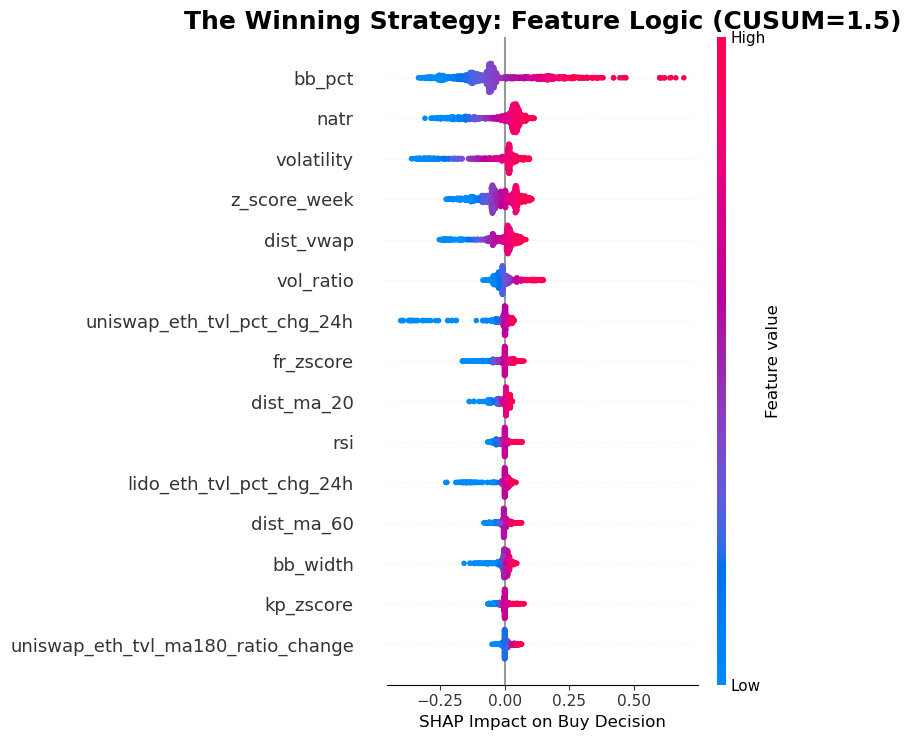

✅ 최종 결과물 저장 완료: shap_beeswarm_WINNER_1.5.png


In [127]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. 데이터 로드 & 1.5만 필터링
# ==========================================
file_path = "shap_values_FULL.csv"
full_df = pd.read_csv(file_path)

# 주인공(Winner)만 선택
target_cusum = 1.5
df_winner = full_df[full_df['CUSUM'] == target_cusum].copy()

print(f"🏆 선택된 모델: CUSUM {target_cusum}")
print(f"📊 분석 데이터: {df_winner.shape[0]}개의 검증된 거래")

# ==========================================
# 2. 메타 데이터 제거 (순수 SHAP 값만 남기기)
# ==========================================
meta_cols = ['CUSUM', 'Strategy', 'Model', 'Fold']
shap_data = df_winner.drop(columns=[c for c in meta_cols if c in df_winner.columns])
shap_data = shap_data.select_dtypes(include=[np.number])

# ==========================================
# 3. Final Beeswarm Plot
# ==========================================
plt.figure(figsize=(12, 10))

# 제목에 'Final'을 박아서 권위를 부여
plt.title(f"The Winning Strategy: Feature Logic (CUSUM={target_cusum})", fontsize=18, fontweight='bold')

shap.summary_plot(
    shap_data.values, 
    shap_data, 
    plot_type="dot", 
    max_display=15, # 상위 15개만 집중 조명
    show=False,
    feature_names=shap_data.columns
)

plt.xlabel(f"SHAP Impact on Buy Decision", fontsize=12)
plt.tight_layout()

# 저장
save_name = "shap_beeswarm_WINNER_1.5.png"
plt.savefig(save_name, dpi=300)
plt.show()

print(f"✅ 최종 결과물 저장 완료: {save_name}")



📂 데이터 로드 성공!
🌟 [CUSUM 1.5] 전설의 거래: 2020-12-16 21:00:00 (Conf: 73.9%)


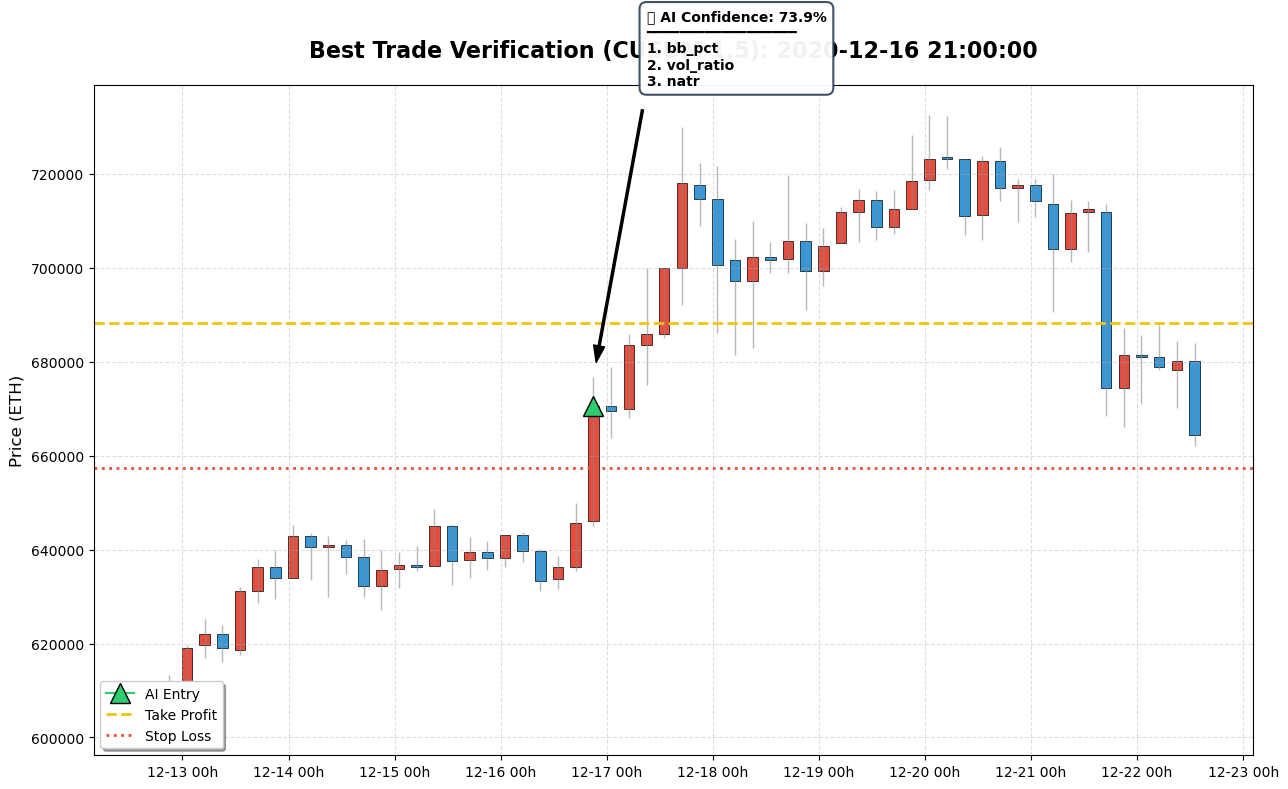

✅ 결과물 저장 완료: legendary_trade_CUSUM_1.5.png


In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import numpy as np

# =========================================================
# 🚨 파일 경로 확인
# =========================================================
PRICE_DATA_PATH = "macro_data_4h/eth_4hour.csv" 
LOG_DATA_PATH = "grid_search_result_1208_catboost_1/backend_deployment_logs_FULL.csv"

# 우리가 보고 싶은 주인공 CUSUM 값
TARGET_CUSUM = 1.5
# =========================================================

def plot_legendary_trade_candle():
    # 0. 파일 체크
    if not os.path.exists(LOG_DATA_PATH):
        print(f"❌ 로그 파일 없음: {LOG_DATA_PATH}")
        return
    if not os.path.exists(PRICE_DATA_PATH):
        print(f"❌ 가격 파일 없음: {PRICE_DATA_PATH}")
        return

    # 1. 데이터 로드
    try:
        log_df = pd.read_csv(LOG_DATA_PATH)
        price_df = pd.read_csv(PRICE_DATA_PATH)
        
        # 가격 데이터 전처리
        price_df.columns = price_df.columns.str.lower().str.strip()
        time_cols = [c for c in price_df.columns if 'time' in c or 'date' in c]
        if not time_cols:
            print("❌ 날짜 컬럼 없음")
            return
        
        time_col = time_cols[0]
        price_df[time_col] = pd.to_datetime(price_df[time_col])
        price_df.set_index(time_col, inplace=True)
        price_df.sort_index(inplace=True)
        
        print("📂 데이터 로드 성공!")
        
    except Exception as e:
        print(f"❌ 데이터 로드 에러: {e}")
        return

    # 2. 최고의 거래 찾기 (CUSUM 1.5 필터링 추가!)
    # 조건: CUSUM 1.5  AND  BUY  AND  Correct
    success_trades = log_df[
        (log_df['cusum_multiplier'] == TARGET_CUSUM) & 
        (log_df['final_action'] == 'BUY') & 
        (log_df['correct'] == True)
    ]
    
    if success_trades.empty:
        print(f"⚠️ CUSUM {TARGET_CUSUM}에서 성공한 거래가 없습니다.")
        # 혹시 모르니 전체에서라도 찾기 (옵션)
        return
        
    # 확신도(Confidence) 1등 뽑기
    best_trade = success_trades.sort_values('confidence', ascending=False).iloc[0]
    
    # 정보 추출
    signal_time = pd.to_datetime(best_trade['signal_time'])
    entry_price = float(best_trade['entry_price'])
    tp_price = float(best_trade['tp_price'])
    sl_price = float(best_trade['sl_price'])
    conf = float(best_trade['confidence'])
    reasons = [best_trade['Reason_1'], best_trade['Reason_2'], best_trade['Reason_3']]

    print(f"🌟 [CUSUM {TARGET_CUSUM}] 전설의 거래: {signal_time} (Conf: {conf:.1%})")

    # 3. 차트 구간 자르기 (전후 30개)
    try:
        target_idx = price_df.index.get_indexer([signal_time], method='nearest')[0]
        start_pos = max(0, target_idx - 25)
        end_pos = min(len(price_df), target_idx + 35)
        subset = price_df.iloc[start_pos:end_pos].copy()
    except:
        print("❌ 날짜 인덱싱 실패")
        return

    # 4. OHLC 컬럼명 자동 매핑
    def get_col(candidates):
        for c in candidates:
            if c in subset.columns: return subset[c]
        return None

    o = get_col(['eth_open', 'open', 'o'])
    h = get_col(['eth_high', 'high', 'h'])
    l = get_col(['eth_low', 'low', 'l'])
    c = get_col(['eth_close', 'close', 'c'])

    if o is None or c is None:
        print("❌ OHLC 컬럼 없음")
        return

    # 5. 캔들 그리기
    fig, ax = plt.subplots(figsize=(13, 8))
    
    up_mask = c >= o
    down_mask = c < o
    
    if len(subset) > 1:
        dt = (subset.index[1] - subset.index[0]).total_seconds() / (24*3600)
        width = dt * 0.6
    else:
        width = 0.05

    ax.vlines(subset.index, l, h, color='#7f8c8d', linewidth=1, alpha=0.6)
    ax.bar(subset.index[up_mask], c[up_mask] - o[up_mask], bottom=o[up_mask], width=width, color='#e74c3c', edgecolor='black', linewidth=0.5)
    ax.bar(subset.index[down_mask], c[down_mask] - o[down_mask], bottom=o[down_mask], width=width, color='#3498db', edgecolor='black', linewidth=0.5)

    # 6. AI 매매 마킹
    ax.plot(signal_time, entry_price, marker='^', color='#2ecc71', markersize=14, markeredgecolor='black', label='AI Entry', zorder=10)
    ax.axhline(tp_price, color='#f1c40f', linestyle='--', linewidth=2, label='Take Profit')
    ax.axhline(sl_price, color='#e74c3c', linestyle=':', linewidth=2, label='Stop Loss')
    
    # 7. 설명 박스
    box_text = (
        f"🤖 AI Confidence: {conf:.1%}\n"
        f"━━━━━━━━━━━━━━━━━━\n"
        f"1. {reasons[0]}\n"
        f"2. {reasons[1]}\n"
        f"3. {reasons[2]}"
    )
    
    # 텍스트 위치 계산 (캔들 위쪽)
    text_y_pos = h.max() + (h.max() - l.min()) * 0.05
    
    ax.annotate(
        box_text,
        xy=(signal_time, h.loc[signal_time] if signal_time in h.index else entry_price),
        xytext=(signal_time + pd.Timedelta(hours=12), text_y_pos),
        arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="#34495e", alpha=0.95, lw=1.5),
        fontsize=10, fontweight='bold', zorder=20
    )

    ax.set_title(f"Best Trade Verification (CUSUM {TARGET_CUSUM}): {signal_time}", fontsize=16, fontweight='bold', pad=20)
    ax.set_ylabel("Price (ETH)", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(loc='lower left', shadow=True)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %Hh'))
    plt.tight_layout()
    
    save_file = f"legendary_trade_CUSUM_{TARGET_CUSUM}.png"
    plt.savefig(save_file, dpi=300)
    plt.show()
    print(f"✅ 결과물 저장 완료: {save_file}")

# 실행
plot_legendary_trade_candle()


🌟 분석 대상: Index 7650 (Total Score: 1.04)
👉 Top 1 Feature: bb_pct (+0.6014)


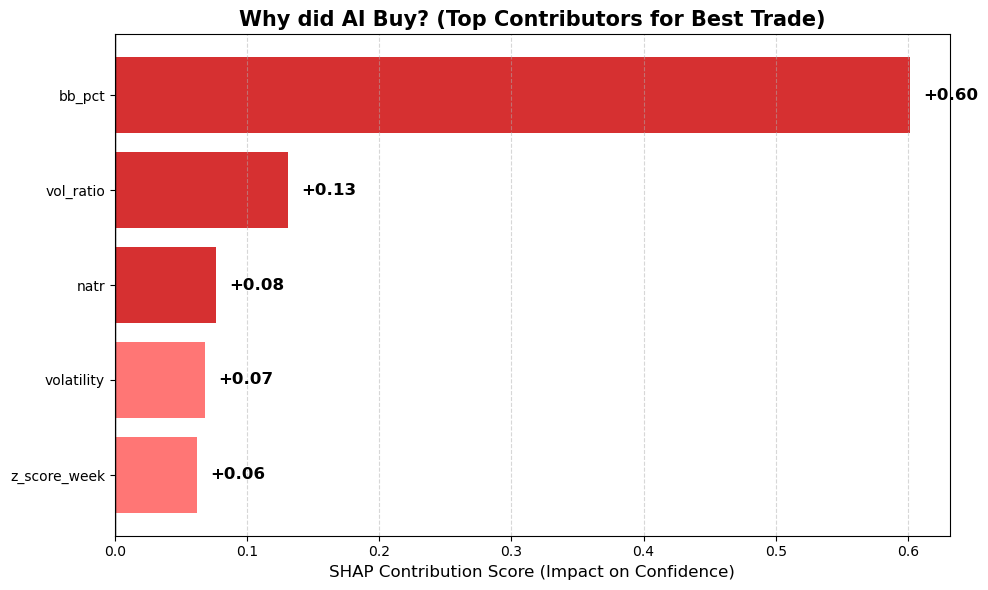

✅ 채점표 저장 완료: legendary_trade_reasoning_bar.png


In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# =========================================================
# 🚨 파일 경로 설정
# =========================================================
SHAP_DATA_PATH = "shap_values_FULL.csv"
TARGET_CUSUM = 1.5
# =========================================================

def plot_best_trade_contribution():
    # 1. 데이터 로드
    try:
        full_df = pd.read_csv(SHAP_DATA_PATH)
        df = full_df[full_df['CUSUM'] == TARGET_CUSUM].copy()
        
        # 메타 데이터 제거 (순수 점수판만 남기기)
        meta_cols = ['CUSUM', 'Strategy', 'Model', 'Fold']
        feature_cols = [c for c in df.columns if c not in meta_cols]
        shap_vals = df[feature_cols]
        
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return

    # 2. 1등 거래 찾기 (매수 점수 총합이 가장 큰 행)
    # axis=1 합계가 가장 큰 행이 곧 '가장 강력한 매수 신호'를 보낸 날입니다.
    total_scores = shap_vals.sum(axis=1)
    best_idx = total_scores.idxmax()
    
    # 3. 그날의 점수표 뽑기
    best_shap_row = shap_vals.loc[best_idx]
    
    # 상위 5개만 추리기 (점수 순 정렬)
    top_contributors = best_shap_row.sort_values(ascending=False).head(5)
    
    print(f"🌟 분석 대상: Index {best_idx} (Total Score: {total_scores[best_idx]:.2f})")
    print(f"👉 Top 1 Feature: {top_contributors.index[0]} (+{top_contributors.iloc[0]:.4f})")

    # 4. 시각화 (수평 막대 그래프)
    plt.figure(figsize=(10, 6))
    
    # 색상: 1,2,3등은 진한 빨강, 나머지는 연한 빨강
    colors = ['#d63031' if i < 3 else '#ff7675' for i in range(len(top_contributors))]
    
    # 가로 막대 그리기
    bars = plt.barh(top_contributors.index, top_contributors.values, color=colors)
    plt.gca().invert_yaxis() # 1등이 맨 위로 오게 뒤집기
    
    # 막대 옆에 수치 쓰기
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                 f"+{width:.2f}", va='center', fontweight='bold', fontsize=12, color='black')

    # 스타일링
    plt.title(f"Why did AI Buy? (Top Contributors for Best Trade)", fontsize=15, fontweight='bold')
    plt.xlabel("SHAP Contribution Score (Impact on Confidence)", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    
    # 3등까지 강조 박스
    plt.axvline(0, color='black', linewidth=1)
    
    plt.tight_layout()
    save_name = "legendary_trade_reasoning_bar.png"
    plt.savefig(save_name, dpi=300)
    plt.show()
    print(f"✅ 채점표 저장 완료: {save_name}")

plot_best_trade_contribution()



In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import numpy as np

# =========================================================
# 파일 경로 (확인 필수!)
# =========================================================
PRICE_DATA_PATH = "macro_data_4h/eth_4hour.csv" 
LOG_DATA_PATH = "grid_search_result_1208_catboost_1/backend_deployment_logs_FULL.csv"
TARGET_CUSUM = 1.5
# =========================================================

def plot_color_coded_evidence():
    # 0. 파일 로드 (생략 - 위와 동일)
    if not os.path.exists(LOG_DATA_PATH) or not os.path.exists(PRICE_DATA_PATH): return
    try:
        log_df = pd.read_csv(LOG_DATA_PATH)
        price_df = pd.read_csv(PRICE_DATA_PATH)
        price_df.columns = price_df.columns.str.lower().str.strip()
        time_col = [c for c in price_df.columns if 'time' in c or 'date' in c][0]
        price_df[time_col] = pd.to_datetime(price_df[time_col])
        price_df.set_index(time_col, inplace=True)
        price_df.sort_index(inplace=True)
        
        # 지표 계산
        ma20 = price_df['eth_close'].rolling(20).mean()
        std20 = price_df['eth_close'].rolling(20).std()
        price_df['bb_upper'] = ma20 + 2 * std20
        
        h, l, c_prev = price_df['eth_high'], price_df['eth_low'], price_df['eth_close'].shift(1)
        tr = np.maximum(h - l, np.maximum(abs(h - c_prev), abs(l - c_prev)))
        atr = tr.rolling(14).mean()
        price_df['natr'] = (atr / price_df['eth_close']) * 100
    except: return

    # 2. 거래 찾기
    success_trades = log_df[(log_df['cusum_multiplier'] == TARGET_CUSUM) & (log_df['final_action'] == 'BUY') & (log_df['correct'] == True)]
    if success_trades.empty: return
    best_trade = success_trades.sort_values('confidence', ascending=False).iloc[0]
    
    signal_time = pd.to_datetime(best_trade['signal_time'])
    entry_price = float(best_trade['entry_price'])
    tp_price = float(best_trade['tp_price'])
    
    # 실제 이유 가져오기
    reasons = [best_trade['Reason_1'], best_trade['Reason_2'], best_trade['Reason_3']]
    
    # 3. 데이터 자르기
    target_idx = price_df.index.get_indexer([signal_time], method='nearest')[0]
    subset = price_df.iloc[max(0, target_idx-25) : min(len(price_df), target_idx+35)].copy()

    # =========================================================
    # 4. 그리기 (Super Vivid Mode)
    # =========================================================
    fig, ax1 = plt.subplots(figsize=(15, 10)) # 사이즈 키움
    
    # [Color Palette Definition]
    COL_BB = '#FF6600'      # 주황 (볼린저 밴드)
    COL_VOL = '#00CED1'     # 청록 (거래량)
    COL_NATR = '#FF00FF'    # 핑크 (변동성)
    COL_ENTRY = '#32CD32'   # 라임그린 (진입)
    COL_TP = '#FFD700'      # 골드 (익절)

    # [Layer 1] 볼린저 밴드 (주황색)
    ax1.plot(subset.index, subset['bb_upper'], color=COL_BB, linestyle='--', linewidth=2.5)
    # 텍스트 라벨 직접 달기
    ax1.text(subset.index[-1], subset['bb_upper'].iloc[-1], ' Resistance (BB)', color=COL_BB, fontweight='bold', fontsize=12, va='center')

    # [Layer 2] 캔들 차트
    width = (subset.index[1] - subset.index[0]).total_seconds() / (24*3600) * 0.6
    up = subset[subset['eth_close'] >= subset['eth_open']]
    down = subset[subset['eth_close'] < subset['eth_open']]
    
    ax1.vlines(subset.index, subset['eth_low'], subset['eth_high'], color='black', lw=1)
    ax1.bar(up.index, up['eth_close']-up['eth_open'], bottom=up['eth_open'], width=width, color='white', edgecolor='red', linewidth=1.5)
    ax1.bar(down.index, down['eth_close']-down['eth_open'], bottom=down['eth_open'], width=width, color='black', edgecolor='blue', linewidth=1.5)

    # [Layer 3] AI Entry & TP
    ax1.plot(signal_time, entry_price, marker='^', color=COL_ENTRY, markersize=22, markeredgecolor='black', markeredgewidth=2, zorder=10)
    ax1.axhline(tp_price, color=COL_TP, linestyle='-', linewidth=3)
    ax1.text(subset.index[-1], tp_price, ' Take Profit', color='#DAA520', fontweight='bold', fontsize=12, va='center')

    # [Layer 4] 거래량 (청록색)
    price_range = subset['eth_high'].max() - subset['eth_low'].min()
    vol_scale = price_range / subset['eth_volume'].max() * 0.25 
    base_line = subset['eth_low'].min() - price_range * 0.1
    ax1.bar(subset.index, subset['eth_volume'] * vol_scale + base_line, bottom=base_line, width=width, color=COL_VOL, alpha=0.9)
    
    # [Layer 5] NATR (핑크색)
    ax2 = ax1.twinx()
    ax2.plot(subset.index, subset['natr'], color=COL_NATR, lw=3.5)
    ax2.set_ylabel('Volatility (NATR)', color=COL_NATR, fontweight='bold', fontsize=14)
    ax2.tick_params(axis='y', labelcolor=COL_NATR)

    # [Highlight Box] 색상 코딩된 설명 박스
    # matplotlib에서는 텍스트마다 색을 다르게 하려면 좌표를 따로 찍어야 하므로,
    # 여기서는 박스 안에 텍스트를 넣되, 괄호 안에 색상명을 명시해서 연결해줍니다.
    
    box_text = (
        f"🎯 AI DECISION LOGIC\n"
        f"━━━━━━━━━━━━━━━━━━━\n"
        f"1. {reasons[0]} ➤ Orange Line ({COL_BB})\n"
        f"2. {reasons[1]} ➤Teal Bar ({COL_VOL})\n"
        f"3. {reasons[2]} ➤ Pink Line ({COL_NATR})"
    )
    
    # 텍스트 박스 그리기
    t = ax1.annotate(box_text, xy=(signal_time, entry_price), 
                 xytext=(signal_time+pd.Timedelta(hours=6), subset['eth_high'].max()),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=2),
                 bbox=dict(boxstyle="round,pad=0.6", fc="white", ec="black", lw=2),
                 fontsize=11, fontweight='bold', zorder=20)

    # 타이틀
    ax1.set_title(f"AI Trade Verification: {signal_time}\n(Match the Colors: Orange, Teal, Pink)", fontsize=18, fontweight='bold')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %Hh'))
    
    plt.tight_layout()
    save_file = "legendary_trade_color_coded.png"
    plt.savefig(save_file, dpi=300)
    plt.show()
    print(f"✅ 색상 매칭 차트 저장 완료: {save_file}")

plot_color_coded_evidence()


✅ 색상 매칭 차트 저장 완료: legendary_trade_color_coded.png
